<a href="https://colab.research.google.com/github/Masyithah28/PembelajaranMesin_Ganjil_2024/blob/main/Jobsheet10RNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Jobsheet 10 - Recurrent Neural Network(CNN)   
Nama  : Masyithah Sophia Damayanti   
Kelas : TI - 3C   
No    : 15  
NIM   : 2241720011    
[Github](https://)    
[Google Colab](https://colab.research.google.com/drive/1huRi50xcwl75jC-o24Z9kIVz4CbqVkag?usp=sharing)



## Praktikum 1
### Setup

In [1]:
import numpy as np
import tensorflow_datasets as tfds
import tensorflow as tf

tfds.disable_progress_bar()

In [2]:
import matplotlib.pyplot as plt

def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])

**Penjelasan:**
'plot_graphs' untuk membuat grafik yang menunjukkan perubahan metrik selama pelatihan dan validasi model per epoch.

### Setup Input Pipeline

In [3]:
dataset, info = tfds.load('imdb_reviews', with_info=True,
                          as_supervised=True)
train_dataset, test_dataset = dataset['train'], dataset['test']

train_dataset.element_spec

Dataset imdb_reviews downloaded and prepared to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0. Subsequent calls will reuse this data.


(TensorSpec(shape=(), dtype=tf.string, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None))

**Penjelasan:**
untuk mengambil dataset untuk IMDB dan membagi menjadi data latih dan data uji. Setiap data terdapat ulasan film dan label angka yang mengindetifikasi sentimen positif atau negatif

### Mengembalikan Dataset(teks, pasangan label)

In [4]:
for example, label in train_dataset.take(1):
  print('text: ', example.numpy())
  print('label: ', label.numpy())

text:  b"This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it."
label:  0


**Penjelasan:**  
Berfungsi menampilkan contoh dataset IMDB yaitu teks ulasan dan label. Teks ulasan diatas dengan hasil negatif (label 0), yang menunjukkan bahwa orang tersebut tidak menyukai filmnya.

### Mengacak Data untuk Pelatihan dan membuat kumpulan pasangan (teks, label):

In [5]:
BUFFER_SIZE = 10000
BATCH_SIZE = 64

train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

for example, label in train_dataset.take(1):
  print('texts: ', example.numpy()[:3])
  print()
  print('labels: ', label.numpy()[:3])


texts:  [b"i just happened to stumble on this film channel surfing. my first reaction was, 'oh god not again!'. it's so hip to play a retard these days it has become pretentious and frankly despicable. for some reason, though, i stayed and watched it 'til the end. maybe it was my faith in the actors, hoping they'd give me something to cheer about.<br /><br />and surely, ken and helena can act. also, the movie progresses into something better towards the end and actually does make a point.<br /><br />helena bonham carter also surprised me with her character. jane has a mean side that she uses to keep distance and repel pity. then again she has a soft side that's just looking for love. the only thing that surprised me even more was branagh's character...this was a triumph of acting, the movie itself is nothing unique.<br /><br />see if you are an acting student...if you're looking for pure entertainment you can skip this one. it's sean penn serious! oh my, that was a bit harsh it does fe

**Penjelasan:**   
Berfungsi untuk mengambil 3 contoh data ulasan dari dataset pelatihan IMDB

### Teks Encoder

In [6]:
VOCAB_SIZE = 1000
encoder = tf.keras.layers.TextVectorization(
    max_tokens=VOCAB_SIZE)
encoder.adapt(train_dataset.map(lambda text, label: text))

**Penjelasan:**
Untuk membuat encoder yang merubah teks menjadi angka berdasarkan maksimal 1000 kata unik, kemudian teks akan di train_dataset agar mengenali kata-kata yang paling sering muncul.

### Metode .adapt

In [7]:
vocab = np.array(encoder.get_vocabulary())
vocab[:20]

array(['', '[UNK]', 'the', 'and', 'a', 'of', 'to', 'is', 'in', 'it', 'i',
       'this', 'that', 'br', 'was', 'as', 'for', 'with', 'movie', 'but'],
      dtype='<U14')

**Penjelasan:**   
Kode ditas untuk mengambil 20 kata pertama dari daftar.

### Memberi lapisan untuk mengkodekan teks ke dalam indks

In [8]:
encoded_example = encoder(example)[:3].numpy()
encoded_example

array([[ 10,  41, 562, ...,   0,   0,   0],
       [414,  11,  18, ...,   0,   0,   0],
       [ 10, 103,   9, ...,   0,   0,   0]])

**Penjelasan:**   
Kode untuk mengubah tiga teks ulasan menjadi angka, yang masing-masing diambil untuk mewakili kata dalam teks.

### Mengatur Kosakata terbatas dan kurang fallback dengan karekater yang menghasilkan token tidak diketahui

In [9]:
for n in range(3):
  print("Original: ", example[n].numpy())
  print("Round-trip: ", " ".join(vocab[encoded_example[n]]))
  print()

Original:  b"i just happened to stumble on this film channel surfing. my first reaction was, 'oh god not again!'. it's so hip to play a retard these days it has become pretentious and frankly despicable. for some reason, though, i stayed and watched it 'til the end. maybe it was my faith in the actors, hoping they'd give me something to cheer about.<br /><br />and surely, ken and helena can act. also, the movie progresses into something better towards the end and actually does make a point.<br /><br />helena bonham carter also surprised me with her character. jane has a mean side that she uses to keep distance and repel pity. then again she has a soft side that's just looking for love. the only thing that surprised me even more was branagh's character...this was a triumph of acting, the movie itself is nothing unique.<br /><br />see if you are an acting student...if you're looking for pure entertainment you can skip this one. it's sean penn serious! oh my, that was a bit harsh it does 

**Penjelasan:**   
Untuk menampilkan teks asli dan menampilkan teks yang diubah menjadi angka, kemudian dikembalikan menggunakan bentuk kata asli dengan fungsi vocab

### Build Model

In [10]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=64,
        # Use masking to handle the variable sequence lengths
        mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1)
])

**Penjelasan:**
Model ini mengubah teks jadi angka, memprosesnya dengan LSTM untuk memahami konteks, lalu memberikan prediksi sentimen (positif atau negatif).

### Menggunakan Lapisan RNN

In [11]:
print([layer.supports_masking for layer in model.layers])

[False, True, True, True, True]


**Penjelasan:**   
Untuk memriksa setiap lapisan yang digunakan untuk input.
1. Lapisan pertama (encoder) tidak mendukung masking.
2. Lapisan kedua (Embedding) hingga lapisan terakhir mendukung masking.

In [12]:
import numpy as np
import tensorflow as tf

# Fungsi untuk memproses teks menjadi dataset
def create_dataset(text):
    return tf.data.Dataset.from_tensor_slices([text]).batch(1)

sample_text = ('The movie was cool. The animation and the graphics '
               'were out of this world. I would recommend this movie.')
dataset = create_dataset(sample_text)

# Prediksi menggunakan model
predictions = model.predict(dataset)
print(predictions[0])

1/1 [==============================] - 2s 2s/step
[0.00186378]


**Penjelasan:**   
Untuk membuat dataset dari teks contoh, kemudian menggunakan model untuk memprediksi sentimen teks. Hasil prediksi akan ditampilkan sebagai output pertama dari model.

In [13]:
import numpy as np
import tensorflow as tf

# Fungsi untuk memproses teks menjadi dataset
def create_dataset(texts):
    return tf.data.Dataset.from_tensor_slices(texts).batch(1)

sample_text = ('The movie was cool. The animation and the graphics '
               'were out of this world. I would recommend this movie.')
padding = "the " * 2000  # Padding text
texts = [sample_text, padding]  # List of texts including padding

# Membuat dataset dari teks
dataset = create_dataset(texts)

# Prediksi menggunakan model
predictions = model.predict(dataset)
for pred in predictions:
    print(pred)

2/2 [==============================] - 0s 89ms/step
[0.00186378]
[0.0030128]


**Penjelasan:**   
Membuat dataset dari dua teks ulasan dan satu teks panjang dengan padding, lalu menggunakan model untuk memprediksi sentimen keduanya.

In [14]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

**Penjelasan:**
Untuk mengonfigurasi model dengan fungsi kerugian Binary Crossentropy, optimizer Adam dengan laju pembelajaran 1e-4, dan metrik akurasi untuk evaluasi performa model.

### Train Model

In [15]:
history = model.fit(train_dataset, epochs=10,
                    validation_data=test_dataset,
                    validation_steps=30)

Epoch 1/10
391/391 [==============================] - 231s 572ms/step - loss: 0.6399 - accuracy: 0.5698 - val_loss: 0.5371 - val_accuracy: 0.7063
Epoch 2/10
391/391 [==============================] - 217s 555ms/step - loss: 0.5315 - accuracy: 0.7584 - val_loss: 0.4223 - val_accuracy: 0.7833
Epoch 3/10
391/391 [==============================] - 220s 562ms/step - loss: 0.3958 - accuracy: 0.8203 - val_loss: 0.3877 - val_accuracy: 0.8224
Epoch 4/10
391/391 [==============================] - 223s 569ms/step - loss: 0.3544 - accuracy: 0.8446 - val_loss: 0.3514 - val_accuracy: 0.8380
Epoch 5/10
391/391 [==============================] - 223s 571ms/step - loss: 0.3314 - accuracy: 0.8565 - val_loss: 0.3445 - val_accuracy: 0.8542
Epoch 6/10
391/391 [==============================] - 228s 583ms/step - loss: 0.3188 - accuracy: 0.8607 - val_loss: 0.3288 - val_accuracy: 0.8562
Epoch 7/10
391/391 [==============================] - 223s 571ms/step - loss: 0.3095 - accuracy: 0.8654 - val_loss: 0.3231 -

In [16]:
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

391/391 [==============================] - 66s 168ms/step - loss: 0.3135 - accuracy: 0.8554
Test Loss: 0.3135222792625427
Test Accuracy: 0.855400025844574


**Penjelasan:**
Untuk mengevaluasi model menggunakan dataset pengujian, lalu menampilkan nilai kerugian (loss) dan akurasi model pada data pengujian.

(0.0, 0.6569288015365601)

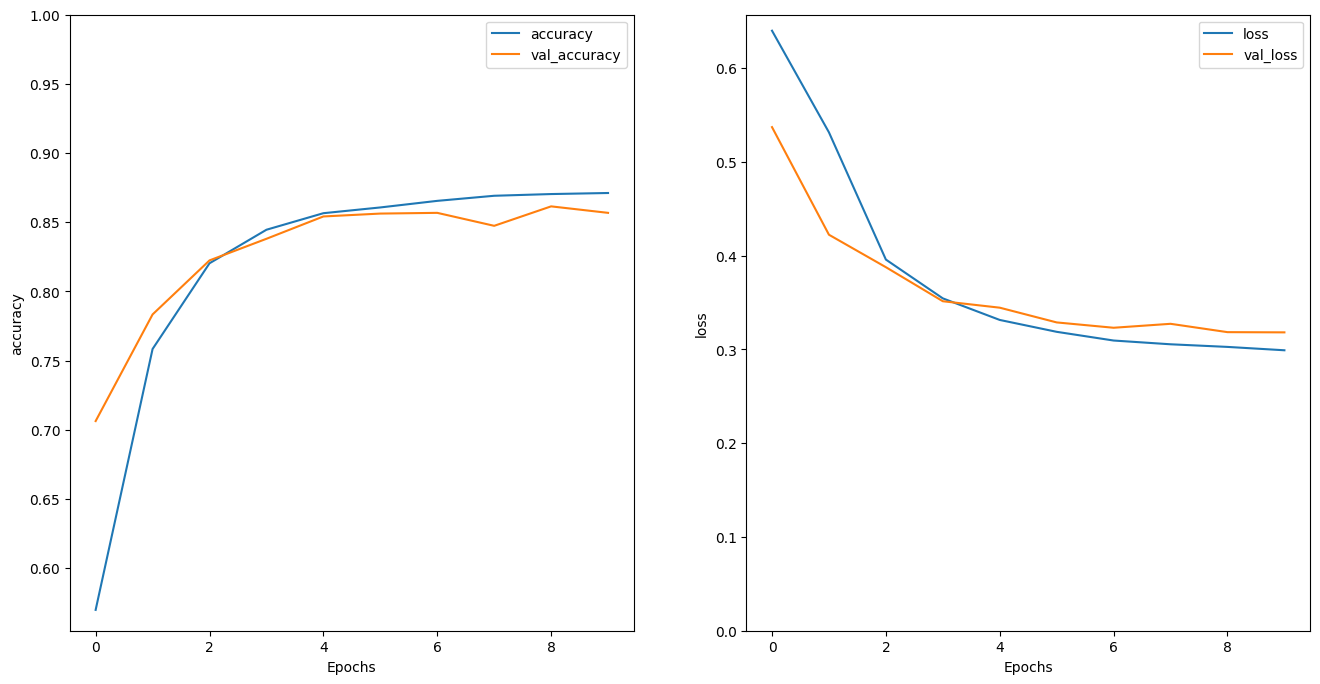

In [17]:
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.ylim(None, 1)
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')
plt.ylim(0, None)

**Penjelasan:**   
Untuk menampilkan dua grafik dalam satu baris: satu akurasi dan satu untuk kerugian (loss) selama pelatihan model.

In [18]:
import numpy as np
import tensorflow as tf

sample_text = ('The movie was cool. The animation and the graphics '
               'were out of this world. I would recommend this movie.')

# Mengonversi teks menjadi tensor
sample_tensor = tf.convert_to_tensor([sample_text])

# Prediksi menggunakan model
predictions = model.predict(sample_tensor)
print(predictions[0])

1/1 [==============================] - 3s 3s/step
[0.5105581]


**Penjelasan:**
Untuk prediksi sentimen dari teks contoh tanpa padding, lalu ditampilkan hasil prediksi model.

### Stack two or more LSTM layers

In [19]:
model = tf.keras.Sequential([
  encoder,
  tf.keras.layers.Embedding(len(encoder.get_vocabulary()), 64, mask_zero=True),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
  tf.keras.layers.Dense(64, activation='relu'),
  tf.keras.layers.Dropout(0.5),
  tf.keras.layers.Dense(1)
])

**Penjelasan:**
Memproses data urutan teks, mengubahnya jadi vektor angka, memahami konteks dari dua arah (maju-mundur), dan mencari pola untuk menghasilkan satu output prediksi.

In [20]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

In [21]:
history = model.fit(train_dataset, epochs=10,
          validation_data=test_dataset,
          validation_steps=30)

Epoch 1/10
391/391 [==============================] - 449s 1s/step - loss: 0.6364 - accuracy: 0.5733 - val_loss: 0.4742 - val_accuracy: 0.7479
Epoch 2/10
391/391 [==============================] - 435s 1s/step - loss: 0.3959 - accuracy: 0.8252 - val_loss: 0.3648 - val_accuracy: 0.8359
Epoch 3/10
391/391 [==============================] - 434s 1s/step - loss: 0.3413 - accuracy: 0.8554 - val_loss: 0.3640 - val_accuracy: 0.8229
Epoch 4/10
391/391 [==============================] - 431s 1s/step - loss: 0.3202 - accuracy: 0.8624 - val_loss: 0.3598 - val_accuracy: 0.8297
Epoch 5/10
391/391 [==============================] - 428s 1s/step - loss: 0.3170 - accuracy: 0.8660 - val_loss: 0.3231 - val_accuracy: 0.8583
Epoch 6/10
391/391 [==============================] - 424s 1s/step - loss: 0.3083 - accuracy: 0.8677 - val_loss: 0.3255 - val_accuracy: 0.8469
Epoch 7/10
391/391 [==============================] - 425s 1s/step - loss: 0.3042 - accuracy: 0.8701 - val_loss: 0.3193 - val_accuracy: 0.8516

In [22]:
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

391/391 [==============================] - 115s 294ms/step - loss: 0.3139 - accuracy: 0.8557
Test Loss: 0.3139404356479645
Test Accuracy: 0.855679988861084


In [ ]:
import numpy as np
import tensorflow as tf

sample_text = ('The movie was not good. The animation and the graphics '
                'were terrible. I would not recommend this movie.')

# Mengonversi teks menjadi tensor
sample_tensor = tf.convert_to_tensor([sample_text])

# Prediksi menggunakan model
predictions = model.predict(sample_tensor)
print(predictions)

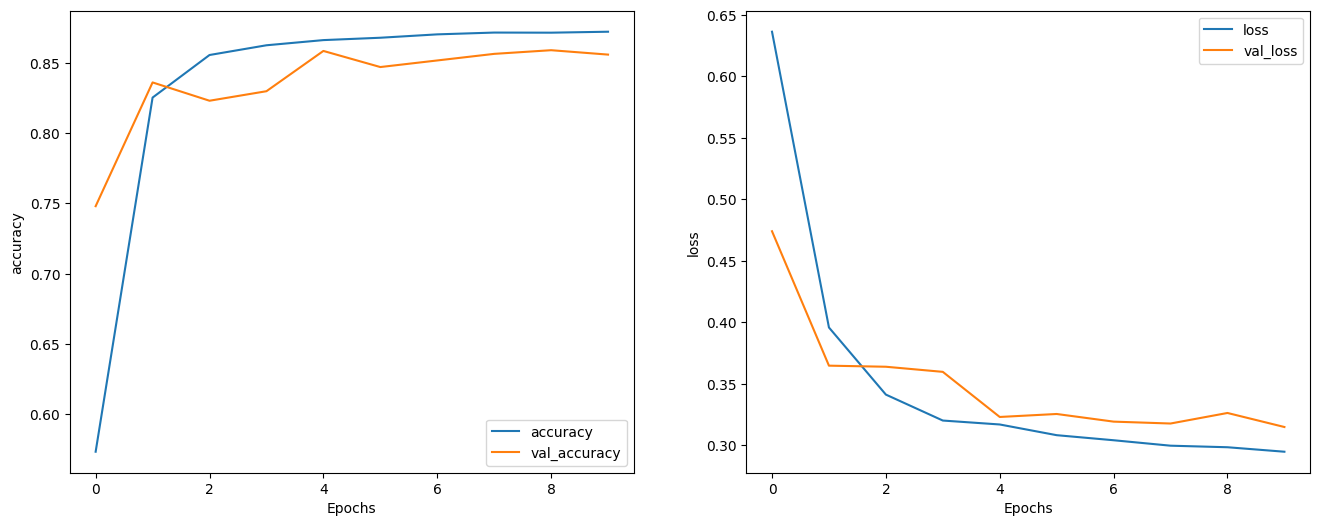

In [24]:
plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')

## Praktikum 2

### Import TensorFlow

In [25]:
import tensorflow as tf
import numpy as np
import os
import time

### Dataset Shakespeare

In [26]:
path_to_file = tf.keras.utils.get_file('shakespeare.txt','https://storage.googleapis.com/download.tensorflow.org/data/shakespeare.txt')

1115394/1115394 [==============================] - 0s 0us/step


### Load Data

In [27]:
# Read, then decode for py2 compat.
text = open(path_to_file, 'rb').read().decode(encoding='utf-8')
# length of text is the number of characters in it
print(f'Length of text: {len(text)} characters')

Length of text: 1115394 characters


**Penjelasan:**
Untuk membuka file dan, membaca isi data biner ('rb'), selanjutnya mengkonversi menjadi teks (utf-8).Panjang teks (jumlah karakter) dihitung dan ditampilkan di layar.

In [28]:
# Take a look at the first 250 characters in text
print(text[:250])

First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You are all resolved rather to die than to famish?

All:
Resolved. resolved.

First Citizen:
First, you know Caius Marcius is chief enemy to the people.



**Penjelasan:**   
Menampilkan 250 karakter pertama dari isi teks.

In [29]:
# The unique characters in the file
vocab = sorted(set(text))
print(f'{len(vocab)} unique characters')

65 unique characters


**Penjelasan:**
Mencari karakter unik dalam teks dengan mengonversinya menjadi himpunan, kemudian mengurutkannya.

### Olah Teks

In [30]:
example_texts = ['abcdefg', 'xyz']
chars = tf.strings.unicode_split(example_texts, input_encoding='UTF-8')
chars

<tf.RaggedTensor [[b'a', b'b', b'c', b'd', b'e', b'f', b'g'], [b'x', b'y', b'z']]>

In [31]:
ids_from_chars = tf.keras.layers.StringLookup(
vocabulary=list(vocab),mask_token=None)

**Penjelasan:**
Untuk membuat layer StringLookup yang berfungsi mengonversi karakter menjadi ID numerik.

In [32]:
ids = ids_from_chars(chars)
ids

<tf.RaggedTensor [[40, 41, 42, 43, 44, 45, 46], [63, 64, 65]]>

**Penjelasan:**
mengonversi karakter chars menjadi ID numerik berdasarkan kamus karakter vocab yang sudah dibuat.

In [33]:
chars_from_ids = tf.keras.layers.StringLookup(
    vocabulary=ids_from_chars.get_vocabulary(), invert=True, mask_token=None)

**Penjelasan:**
'invert=True' untuk membalikkan proses konversi dari ID ke karakter sesuai dengan kamus yang sudah ada.

In [34]:
chars = chars_from_ids(ids)
chars

<tf.RaggedTensor [[b'a', b'b', b'c', b'd', b'e', b'f', b'g'], [b'x', b'y', b'z']]>

**Penjelasan:**
mengonversi ID numerik dalam idsdan dikembalikan menjadi karakter asli menggunakan kamus yang dibalik sebelumnya dengan chars_from_ids

In [35]:
tf.strings.reduce_join(chars, axis=-1).numpy()

array([b'abcdefg', b'xyz'], dtype=object)

**Penjelasan:**
menggabungkan (join) kembali karakter dalam chars menjadi satu string, kemudian mengonversinya ke format numpy untuk memudahkan manipulasi.

In [36]:
def text_from_ids(ids):
    return tf.strings.reduce_join(chars_from_ids(ids), axis=-1)

**Penjelasan:**
Fungsi untuk mengonversi ID numerik menjadi teks dengan menggabungkan karakter-karakter yang sesuai.

## Prediksi

### Membuat Training Set dan Target

In [37]:
all_ids = ids_from_chars(tf.strings.unicode_split(text, 'UTF-8'))
all_ids

<tf.Tensor: shape=(1115394,), dtype=int64, numpy=array([19, 48, 57, ..., 46,  9,  1])>

In [38]:
ids_dataset = tf.data.Dataset.from_tensor_slices(all_ids)

In [39]:
for ids in ids_dataset.take(10):
    print(chars_from_ids(ids).numpy().decode('utf-8'))

F
i
r
s
t
 
C
i
t
i


In [40]:
seq_length = 100

In [41]:
sequences = ids_dataset.batch(seq_length+1, drop_remainder=True)

for seq in sequences.take(1):
  print(chars_from_ids(seq))

tf.Tensor(
[b'F' b'i' b'r' b's' b't' b' ' b'C' b'i' b't' b'i' b'z' b'e' b'n' b':'
 b'\n' b'B' b'e' b'f' b'o' b'r' b'e' b' ' b'w' b'e' b' ' b'p' b'r' b'o'
 b'c' b'e' b'e' b'd' b' ' b'a' b'n' b'y' b' ' b'f' b'u' b'r' b't' b'h'
 b'e' b'r' b',' b' ' b'h' b'e' b'a' b'r' b' ' b'm' b'e' b' ' b's' b'p'
 b'e' b'a' b'k' b'.' b'\n' b'\n' b'A' b'l' b'l' b':' b'\n' b'S' b'p' b'e'
 b'a' b'k' b',' b' ' b's' b'p' b'e' b'a' b'k' b'.' b'\n' b'\n' b'F' b'i'
 b'r' b's' b't' b' ' b'C' b'i' b't' b'i' b'z' b'e' b'n' b':' b'\n' b'Y'
 b'o' b'u' b' '], shape=(101,), dtype=string)


In [42]:
for seq in sequences.take(5):
    print(text_from_ids(seq).numpy())

b'First Citizen:\nBefore we proceed any further, hear me speak.\n\nAll:\nSpeak, speak.\n\nFirst Citizen:\nYou '
b'are all resolved rather to die than to famish?\n\nAll:\nResolved. resolved.\n\nFirst Citizen:\nFirst, you k'
b"now Caius Marcius is chief enemy to the people.\n\nAll:\nWe know't, we know't.\n\nFirst Citizen:\nLet us ki"
b"ll him, and we'll have corn at our own price.\nIs't a verdict?\n\nAll:\nNo more talking on't; let it be d"
b'one: away, away!\n\nSecond Citizen:\nOne word, good citizens.\n\nFirst Citizen:\nWe are accounted poor citi'


In [43]:
def split_input_target(sequence):
    input_text = sequence[:-1]
    target_text = sequence[1:]
    return input_text, target_text

**Penjelasan:**
membagi sebuah urutan menjadi dua bagian: input_text (semua elemen kecuali yang terakhir) dan target_text (semua elemen kecuali yang pertama).

In [44]:
split_input_target(list("Tensorflow"))

(['T', 'e', 'n', 's', 'o', 'r', 'f', 'l', 'o'],
 ['e', 'n', 's', 'o', 'r', 'f', 'l', 'o', 'w'])

In [45]:
dataset = sequences.map(split_input_target)

In [46]:
for input_example, target_example in dataset.take(1):
    print("Input :", text_from_ids(input_example).numpy())
    print("Target:", text_from_ids(target_example).numpy())

Input : b'First Citizen:\nBefore we proceed any further, hear me speak.\n\nAll:\nSpeak, speak.\n\nFirst Citizen:\nYou'
Target: b'irst Citizen:\nBefore we proceed any further, hear me speak.\n\nAll:\nSpeak, speak.\n\nFirst Citizen:\nYou '


### Membuat Batch Training

In [47]:
# Batch size
BATCH_SIZE = 64

# Buffer size to shuffle the dataset
# (TF data is designed to work with possibly infinite sequences,
# so it doesn't attempt to shuffle the entire sequence in memory. Instead,
# it maintains a buffer in which it shuffles elements).
BUFFER_SIZE = 10000

dataset = (
    dataset
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE, drop_remainder=True)
    .prefetch(tf.data.experimental.AUTOTUNE))

dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(64, 100), dtype=tf.int64, name=None), TensorSpec(shape=(64, 100), dtype=tf.int64, name=None))>

**Penjelasan:**
Untuk mengacak, membagi dataset menjadi batch, dan memuat data secara paralel untuk efisiensi.

### Membuat Model

In [48]:
# Length of the vocabulary in StringLookup Layer
vocab_size = len(ids_from_chars.get_vocabulary())

# The embedding dimension
embedding_dim = 256

# Number of RNN units
rnn_units = 1024

**Penjelasan:**
Untuk mendefinisikan tiga hal: ukuran vocab (jumlah karakter unik), dimensi embedding (256), dan jumlah unit RNN (1024) yang akan digunakan dalam model

In [49]:
class MyModel(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim, rnn_units):
    super().__init__(self)
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = tf.keras.layers.GRU(rnn_units,
                                   return_sequences=True,
                                   return_state=True)
    self.dense = tf.keras.layers.Dense(vocab_size)

  def call(self, inputs, states=None, return_state=False, training=False):
    x = inputs
    x = self.embedding(x, training=training)
    if states is None:
      states = self.gru.get_initial_state(x)
    x, states = self.gru(x, initial_state=states, training=training)
    x = self.dense(x, training=training)

    if return_state:
      return x, states
    else:
      return x

**Penjelasan:**
Model ini menggunakan lapisan embedding, GRU, dan dense untuk memproses urutan data dan menghasilkan prediksi.

In [50]:
model = MyModel(
    vocab_size=vocab_size,
    embedding_dim=embedding_dim,
    rnn_units=rnn_units)

## Tugas

In [51]:
class CustomTraining(MyModel):
  @tf.function
  def train_step(self, inputs):
    inputs, labels = inputs
    with tf.GradientTape() as tape:
      predictions = self(inputs, training=True)
      loss = self.loss(labels, predictions)
    grads = tape.gradient(loss, model.trainable_variables)
    self.optimizer.apply_gradients(zip(grads, model.trainable_variables))

    return {'loss': loss}

In [52]:
model = CustomTraining(
    vocab_size=len(ids_from_chars.get_vocabulary()),
    embedding_dim=embedding_dim,
    rnn_units=rnn_units)

In [53]:
model.compile(optimizer = tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True))

In [54]:
model.fit(dataset, epochs=1)

172/172 [==============================] - 127s 716ms/step - loss: 2.7122


In [ ]:
EPOCHS = 10

mean = tf.metrics.Mean()

for epoch in range(EPOCHS):
    start = time.time()

    mean.reset_states()
    for (batch_n, (inp, target)) in enumerate(dataset):
        logs = model.train_step([inp, target])
        mean.update_state(logs['loss'])

        if batch_n % 50 == 0:
            template = f"Epoch {epoch+1} Batch {batch_n} Loss {logs['loss']:.4f}"
            print(template)

    # saving (checkpoint) the model every 5 epochs
    if (epoch + 1) % 5 == 0:
        model.save_weights(checkpoint_prefix.format(epoch=epoch))

    print()
    print(f'Epoch {epoch+1} Loss: {mean.result().numpy():.4f}')
    print(f'Time taken for 1 epoch {time.time() - start:.2f} sec')
    print("_"*80)

Epoch 1 Batch 0 Loss 2.1610
Epoch 1 Batch 50 Loss 2.0544
Epoch 1 Batch 100 Loss 1.9618
Epoch 1 Batch 150 Loss 1.8329

Epoch 1 Loss: 1.9874
Time taken for 1 epoch 126.17 sec
________________________________________________________________________________
Epoch 2 Batch 0 Loss 1.7795
Epoch 2 Batch 50 Loss 1.7558
Epoch 2 Batch 100 Loss 1.7135
Epoch 2 Batch 150 Loss 1.6119

Epoch 2 Loss: 1.7080
Time taken for 1 epoch 123.37 sec
________________________________________________________________________________
Epoch 3 Batch 0 Loss 1.5726
Epoch 3 Batch 50 Loss 1.5632
Epoch 3 Batch 100 Loss 1.4879
Epoch 3 Batch 150 Loss 1.5145

Epoch 3 Loss: 1.5467
Time taken for 1 epoch 124.29 sec
________________________________________________________________________________
Epoch 4 Batch 0 Loss 1.4256


**Perbedaan:**  
* Praktikum 2 menggunakan train yang lebih umum dan sederhana dengan model.fit,
* Kode tugas menggunakan train yang khusus dan kompleks.  
  Dalam pendekatan ini, ada penggunaan metode train_step dalam model turunan yang mengatur train pada tingkat batch. Ini melibatkan perhitungan loss, perhitungan gradien, peningkatan bobot model, dan pemanfaatan tf.metrics.Mean untuk menghitung rata-rata loss selama proses train. Dengan pendekatan ini, terdapat tingkat kontrol yang lebih besar dan fleksibilitas dalam mengatur proses train model.